In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from inxss import SpectrumDataset, SpecNeuralRepr, PsiMask
from torch.utils.data import DataLoader

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
spec_dataset = SpectrumDataset(
    '/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Aug01.pt',
    num_wq=50
    )

train_idx, val_test_idx = train_test_split(np.arange(len(spec_dataset)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

train_loader = DataLoader([spec_dataset[i] for i in train_idx], batch_size=10, shuffle=True)
val_loader = DataLoader([spec_dataset[i] for i in val_idx], batch_size=10, shuffle=False)
test_loader = DataLoader([spec_dataset[i] for i in test_idx], batch_size=10, shuffle=False)

In [3]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896838/checkpoints/epoch=2428-step=38864.ckpt'
    )

In [4]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

In [5]:
kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = spec_dataset.data_dict['w_grid']

In [6]:
x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)

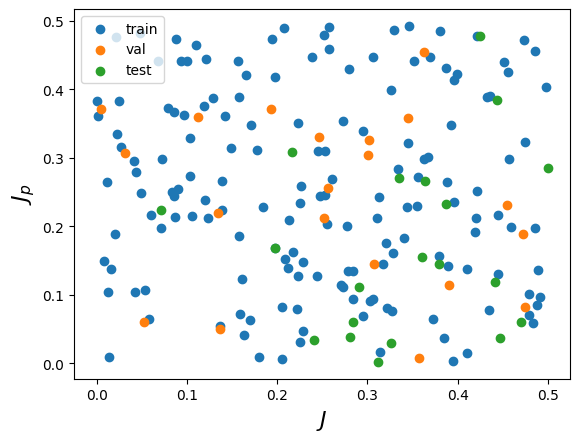

In [7]:
fig, ax = plt.subplots(1,1)
ax.scatter(spec_dataset.data_dict['params'][train_idx,0], spec_dataset.data_dict['params'][train_idx,1], label='train')
ax.scatter(spec_dataset.data_dict['params'][val_idx,0], spec_dataset.data_dict['params'][val_idx,1], label='val')
ax.scatter(spec_dataset.data_dict['params'][test_idx,0], spec_dataset.data_dict['params'][test_idx,1], label='test')
ax.set_xlabel('$J$', fontsize=16)
ax.set_ylabel('$J_{p}$', fontsize=16)
ax.legend()

In [8]:
idx_plot = 2
params = spec_dataset.data_dict['params'][test_idx[idx_plot]]

x[...,:3] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=2)
x[...,3:] = params

S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()

In [9]:
from scipy.interpolate import RegularGridInterpolator
S_true_func = RegularGridInterpolator(
    (np.linspace(0, 0.5, 101), np.linspace(0, 0.5, 101), wpts.numpy()), 
    spec_dataset.data_dict['S'][test_idx[idx_plot]].reshape(-1, 101, 101).permute(1,2,0).numpy(), fill_value=0, bounds_error=False)
S_true = S_true_func(x.detach().numpy()[...,:3])
# plt.imshow(S_true, origin='lower')

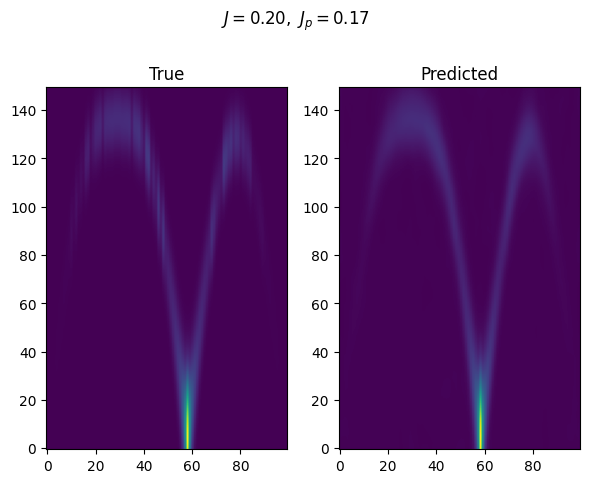

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5))
ax[0].imshow(S_true, origin='lower')
ax[0].set_title('True')
ax[1].imshow(S_pred, origin='lower')
ax[1].set_title('Predicted')

fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()